### Deep Neural Network for SOC Prediction with using Panasonic 18650PF Li-ion Battery

Panasonic 18650PF Li-ion Battery DataSet - https://data.mendeley.com/datasets/wykht8y7tg/1

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import time
from optuna.visualization import plot_optimization_history
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
PROCESSED_DATA_DIR = '../../datasets/Panasonic_dataset/Panasonic_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 1024
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']
                    
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [4]:
# Create Dataset
class BatteryDatasetDNN(Dataset):
    def __init__(self, data_tensor, labels_tensor, filenames=None, times=None):
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        filename = self.filenames[idx]
        time = self.times[idx]  
        return feature, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

In [5]:
# DNN Model
class SoCDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.1):
        super(SoCDNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        # First layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_size))
        self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        # Dynamically add hidden layers
        for i in range(1, num_layers):
            layer_size = hidden_size // (2 ** i)
            self.hidden_layers.append(nn.Linear(hidden_size // (2 ** (i - 1)), layer_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(layer_size))

        # Output layer
        self.output_layer = nn.Linear(hidden_size // (2 ** (num_layers - 1)), 1)

        # Activation and Dropout against Regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for hidden_layer, batch_norm_layer in zip(self.hidden_layers, self.batch_norm_layers):
            x = self.relu(batch_norm_layer(hidden_layer(x)))
            x = self.dropout(x)

        x = self.output_layer(x)
        return x


In [6]:
# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

In [7]:
temperatures_to_process = [folder for folder in os.listdir(PROCESSED_DATA_DIR) if 'degC' in folder]

In [8]:
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 20:16:43,0.093995,4.01846,-2.74303,0.550856,-0.00008,0.000000,-0.000000,1.000000,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-11.022756
1,2017-05-30 20:16:43,0.198993,3.94576,-2.80427,0.347088,-0.00015,0.000029,-0.000082,0.999969,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-11.064976
2,2017-05-30 20:16:43,0.295995,3.90201,-2.85000,0.347088,-0.00024,0.000027,-0.000159,0.999939,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-11.120729
3,2017-05-30 20:16:43,0.398992,3.87370,-2.88430,0.347088,-0.00031,0.000029,-0.000241,0.999908,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-11.172913
4,2017-05-30 20:16:43,0.495994,3.85440,-2.90717,0.347088,-0.00040,0.000027,-0.000319,0.999878,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-11.205396
...,...,...,...,...,...,...,...,...,...,...,...
4979286,2017-06-14 08:01:15,586318.964002,3.80679,-0.07268,-9.940246,-0.89027,0.000026,0.871713,0.397199,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,-0.276677
4979287,2017-06-14 08:01:15,586319.064997,3.80679,-0.07268,-9.940246,-0.89027,0.000028,0.871711,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,-0.276677
4979288,2017-06-14 08:01:15,586319.124995,3.80679,0.00000,-9.940246,-0.89028,0.000017,0.871711,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.000000
4979289,2017-06-14 08:01:15,586319.135999,3.80679,0.00000,-10.158136,-0.89028,0.000003,0.871711,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.000000


In [9]:
scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 20:16:43,0.093995,1.487775,-0.964299,-0.480867,-0.00008,0.000000,1.269774,1.000000,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-1.247924
1,2017-05-30 20:16:43,0.198993,1.229780,-0.997884,-0.495416,-0.00015,0.000029,1.269683,0.999969,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-1.254767
2,2017-05-30 20:16:43,0.295995,1.074522,-1.022964,-0.495416,-0.00024,0.000027,1.269597,0.999939,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-1.263804
3,2017-05-30 20:16:43,0.398992,0.974057,-1.041775,-0.495416,-0.00031,0.000029,1.269505,0.999908,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-1.272262
4,2017-05-30 20:16:43,0.495994,0.905566,-1.054317,-0.495416,-0.00040,0.000027,1.269417,0.999878,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-1.277527
...,...,...,...,...,...,...,...,...,...,...,...
4979286,2017-06-14 08:01:15,586318.964002,0.736610,0.500180,-1.229929,-0.89027,0.000026,2.245124,0.397199,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.493877
4979287,2017-06-14 08:01:15,586319.064997,0.736610,0.500180,-1.229929,-0.89027,0.000028,2.245122,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.493877
4979288,2017-06-14 08:01:15,586319.124995,0.736610,0.540039,-1.229929,-0.89028,0.000017,2.245122,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.538723
4979289,2017-06-14 08:01:15,586319.135999,0.736610,0.540039,-1.245487,-0.89028,0.000003,2.245122,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.538723


In [10]:
unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=52)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=52)

In [11]:
def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)

In [12]:
# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

In [13]:
# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetDNN(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetDNN(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetDNN(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

In [20]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'03-27-17_09.06 10degC_LA92_Pan18650PF_processed.csv', '06-25-17_03.01 n20degC_Cycle_4_Pan18650PF_processed.csv', '06-07-17_08.39 n10degC_UDDS_Pan18650PF_processed.csv', '06-01-17_10.36 0degC_LA92_NN_Pan18650PF_processed.csv', '06-02-17_10.43 0degC_HWFET_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_NN_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_HWFET_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_UDDS_Pan18650PF_processed.csv', '03-20-17_05.56 25degC_HWFTa_Pan18650PF_processed.csv', '06-07-17_08.39 n10degC_US06_Pan18650PF_processed.csv', '06-01-17_10.36 0degC_LA92_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_UDDS_Pan18650PF_processed.csv', '03-18-17_02.17 25degC_Cycle_1_Pan18650PF_processed.csv', '03-21-17_16.27 25degC_NN_Pan18650PF_processed.csv', '03-20-17_19.27 25degC_HWFTb_Pan18650PF_processed.csv', '06-10-17_18.35 n10degC_Cycle_2_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_HWFET_Pan18650PF_processed.csv', '03-21-17_00.29 25degC_UDDS_Pan

In [16]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([4080375, 5])
Test features shape: torch.Size([326908, 5])
Train labels shape: torch.Size([4080375])
Test labels shape: torch.Size([326908])


## Hyperparameter tuning

In [21]:
EPOCHS = 10
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Model, criterion, optimizer
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.MSELoss()

    # Train and validate the model
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Minimize the last validation loss
    return history['val_loss'][-1]

In [22]:
# Create study object and perform optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  

# Best hyperparameters
best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

# Plot optimization history
optimization_history = plot_optimization_history(study)
optimization_history.show()

[I 2025-08-01 03:55:21,782] A new study created in memory with name: no-name-cecda922-b65b-40ed-bf19-f62b2d7fe937
Epoch: 0/10: 100%|██████████| 3985/3985 [00:26<00:00, 152.66it/s]


Epoch 1/10, Train Loss: 0.05737648874642783, Validation Loss: 0.419962201014189
Time taken for epoch: 26.10643196 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:26<00:00, 149.40it/s]


Epoch 2/10, Train Loss: 0.005641715489024088, Validation Loss: 0.40944993988855727
Time taken for epoch: 26.67460513 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:27<00:00, 144.84it/s]


Epoch 3/10, Train Loss: 0.004214111502531219, Validation Loss: 0.318347491703775
Time taken for epoch: 27.51538396 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:27<00:00, 143.59it/s]


Epoch 4/10, Train Loss: 0.004308267335209954, Validation Loss: 0.3239740458207337
Time taken for epoch: 27.75405622 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:28<00:00, 142.11it/s]


Epoch 5/10, Train Loss: 0.004309541741596392, Validation Loss: 0.32864011137856003
Time taken for epoch: 28.04344606 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:28<00:00, 142.22it/s]


Epoch 6/10, Train Loss: 0.004319122397204116, Validation Loss: 0.3292663987526883
Time taken for epoch: 28.02149487 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:28<00:00, 140.55it/s]


Epoch 7/10, Train Loss: 0.004318891751546053, Validation Loss: 0.3299033583611543
Time taken for epoch: 28.35445619 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:28<00:00, 138.77it/s]


Epoch 8/10, Train Loss: 0.004322607591958574, Validation Loss: 0.3301696545653147
Time taken for epoch: 28.71901321 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:28<00:00, 137.47it/s]


Epoch 9/10, Train Loss: 0.00431708429514698, Validation Loss: 0.32269838762744263
Time taken for epoch: 28.98994517 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:29<00:00, 136.72it/s]
[I 2025-08-01 04:00:30,332] Trial 0 finished with value: 0.3290756366506078 and parameters: {'learning_rate': 0.00013033634990185377, 'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.2405012975785851}. Best is trial 0 with value: 0.3290756366506078.


Epoch 10/10, Train Loss: 0.00431965118235531, Validation Loss: 0.3290756366506078
Time taken for epoch: 29.14970493 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:37<00:00, 107.37it/s]


Epoch 1/10, Train Loss: 0.30664243691202386, Validation Loss: 0.08051570186891975
Time taken for epoch: 37.11754704 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:36<00:00, 108.11it/s]


Epoch 2/10, Train Loss: 0.05629842393941607, Validation Loss: 0.1154775452210378
Time taken for epoch: 36.86159396 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.65it/s]


Epoch 3/10, Train Loss: 0.023996899969212084, Validation Loss: 0.1662980750094426
Time taken for epoch: 38.82105613 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:40<00:00, 98.52it/s] 


Epoch 4/10, Train Loss: 0.015136367865047013, Validation Loss: 0.21010170238942774
Time taken for epoch: 40.45065689 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:39<00:00, 99.99it/s] 


Epoch 5/10, Train Loss: 0.010105237139358536, Validation Loss: 0.2132924772909487
Time taken for epoch: 39.85547400 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:39<00:00, 101.88it/s]


Epoch 6/10, Train Loss: 0.008211162950904337, Validation Loss: 0.1972781654746959
Time taken for epoch: 39.11651921 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3985/3985 [00:39<00:00, 101.98it/s]


Epoch 7/10, Train Loss: 0.007477018514524215, Validation Loss: 0.19911591174597026
Time taken for epoch: 39.07687402 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.61it/s]


Epoch 8/10, Train Loss: 0.0071639514032755995, Validation Loss: 0.20388120217870084
Time taken for epoch: 38.83707690 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.24it/s]


Epoch 9/10, Train Loss: 0.007042377500781974, Validation Loss: 0.20640201109305634
Time taken for epoch: 38.97957563 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.48it/s]
[I 2025-08-01 04:07:31,496] Trial 1 finished with value: 0.21918709013724624 and parameters: {'learning_rate': 2.4317234258432755e-05, 'hidden_size': 64, 'num_layers': 4, 'dropout_rate': 0.16571164062609123}. Best is trial 1 with value: 0.21918709013724624.


Epoch 10/10, Train Loss: 0.006953236313683999, Validation Loss: 0.21918709013724624
Time taken for epoch: 38.88755989 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:37<00:00, 105.07it/s]


Epoch 1/10, Train Loss: 0.45575434773075985, Validation Loss: 0.06740057240775267
Time taken for epoch: 37.92692900 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:37<00:00, 106.74it/s]


Epoch 2/10, Train Loss: 0.06917052523816096, Validation Loss: 0.1019203839980707
Time taken for epoch: 37.33401608 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:37<00:00, 105.95it/s]


Epoch 3/10, Train Loss: 0.03849527632287111, Validation Loss: 0.1107282109172719
Time taken for epoch: 37.61504602 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:36<00:00, 107.77it/s]


Epoch 4/10, Train Loss: 0.03731858073786331, Validation Loss: 0.11459985531875844
Time taken for epoch: 36.97898698 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:36<00:00, 107.76it/s]


Epoch 5/10, Train Loss: 0.03710342819382959, Validation Loss: 0.11948764227180779
Time taken for epoch: 36.98078227 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:37<00:00, 106.88it/s]


Epoch 6/10, Train Loss: 0.03706488392480568, Validation Loss: 0.11755177333135003
Time taken for epoch: 37.28507805 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3985/3985 [00:37<00:00, 106.88it/s]


Epoch 7/10, Train Loss: 0.03706065298687933, Validation Loss: 0.11683362216366852
Time taken for epoch: 37.28668499 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3985/3985 [00:37<00:00, 107.00it/s]


Epoch 8/10, Train Loss: 0.03714413673171734, Validation Loss: 0.11874935976184964
Time taken for epoch: 37.24564290 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:38<00:00, 104.36it/s]


Epoch 9/10, Train Loss: 0.037097383518159915, Validation Loss: 0.11254689345135055
Time taken for epoch: 38.18689322 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:37<00:00, 105.28it/s]
[I 2025-08-01 04:14:18,863] Trial 2 finished with value: 0.1146471808586346 and parameters: {'learning_rate': 0.00020838698490646261, 'hidden_size': 16, 'num_layers': 4, 'dropout_rate': 0.26829767971402096}. Best is trial 2 with value: 0.1146471808586346.


Epoch 10/10, Train Loss: 0.03710991315814752, Validation Loss: 0.1146471808586346
Time taken for epoch: 37.85438490 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:31<00:00, 126.18it/s]


Epoch 1/10, Train Loss: 0.13761056213729653, Validation Loss: 0.19486393482987757
Time taken for epoch: 31.58366489 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:31<00:00, 126.94it/s]


Epoch 2/10, Train Loss: 0.018098568631899327, Validation Loss: 0.20565421112751828
Time taken for epoch: 31.39483905 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:30<00:00, 128.66it/s]


Epoch 3/10, Train Loss: 0.014283322232309145, Validation Loss: 0.19428480509367269
Time taken for epoch: 30.97592974 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:30<00:00, 130.04it/s]


Epoch 4/10, Train Loss: 0.014236771032316995, Validation Loss: 0.19274419552191485
Time taken for epoch: 30.64672494 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:30<00:00, 129.15it/s]


Epoch 5/10, Train Loss: 0.014243596215432083, Validation Loss: 0.1926522678296873
Time taken for epoch: 30.85690498 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:30<00:00, 128.99it/s]


Epoch 6/10, Train Loss: 0.014253212574874068, Validation Loss: 0.19508033924555054
Time taken for epoch: 30.89494610 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:30<00:00, 129.67it/s]


Epoch 7/10, Train Loss: 0.014241230814779642, Validation Loss: 0.19307208221657357
Time taken for epoch: 30.73408103 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:30<00:00, 129.35it/s]


Epoch 8/10, Train Loss: 0.01424077959354953, Validation Loss: 0.18876951035930564
Time taken for epoch: 30.81047297 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:31<00:00, 127.27it/s]


Epoch 9/10, Train Loss: 0.014247915458630588, Validation Loss: 0.19309078536915777
Time taken for epoch: 31.31411886 seconds


Epoch: 9/10: 100%|██████████| 3985/3985 [00:30<00:00, 129.11it/s]
[I 2025-08-01 04:20:01,046] Trial 3 finished with value: 0.19227300761798857 and parameters: {'learning_rate': 0.00012986725098703677, 'hidden_size': 16, 'num_layers': 1, 'dropout_rate': 0.461934457124216}. Best is trial 2 with value: 0.1146471808586346.


Epoch 10/10, Train Loss: 0.014236230802823938, Validation Loss: 0.19227300761798857
Time taken for epoch: 30.86692715 seconds


Epoch: 0/10: 100%|██████████| 3985/3985 [00:31<00:00, 126.02it/s]


Epoch 1/10, Train Loss: 0.0233624076447362, Validation Loss: 0.2982442424044636
Time taken for epoch: 31.62339139 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:31<00:00, 127.95it/s]


Epoch 2/10, Train Loss: 0.006380424998850191, Validation Loss: 0.29200800577430647
Time taken for epoch: 31.14804983 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:31<00:00, 127.10it/s]


Epoch 3/10, Train Loss: 0.006337073130516739, Validation Loss: 0.2931194077302275
Time taken for epoch: 31.35531378 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:31<00:00, 126.32it/s]


Epoch 4/10, Train Loss: 0.006332170755989204, Validation Loss: 0.29965646036992216
Time taken for epoch: 31.54992485 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:31<00:00, 127.89it/s]


Epoch 5/10, Train Loss: 0.006324926109393238, Validation Loss: 0.3139384865278524
Time taken for epoch: 31.16079116 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:31<00:00, 126.65it/s]


Epoch 6/10, Train Loss: 0.006331597424931404, Validation Loss: 0.29813865802734424
Time taken for epoch: 31.46775985 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:31<00:00, 125.64it/s]


Epoch 7/10, Train Loss: 0.006341475206269524, Validation Loss: 0.3026775917826191
Time taken for epoch: 31.71933007 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3985/3985 [00:32<00:00, 124.17it/s]


Epoch 8/10, Train Loss: 0.006343213048935347, Validation Loss: 0.28922018405831756
Time taken for epoch: 32.09458685 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:33<00:00, 119.16it/s]


Epoch 9/10, Train Loss: 0.00634210893049967, Validation Loss: 0.31589217981982465
Time taken for epoch: 33.44555616 seconds


Epoch: 9/10: 100%|██████████| 3985/3985 [00:31<00:00, 126.57it/s]
[I 2025-08-01 04:25:49,691] Trial 4 finished with value: 0.2996275697004029 and parameters: {'learning_rate': 0.00033508688442819784, 'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.2934227667571474}. Best is trial 2 with value: 0.1146471808586346.


Epoch 10/10, Train Loss: 0.006325598931643491, Validation Loss: 0.2996275697004029
Time taken for epoch: 31.48723722 seconds


Epoch: 0/10: 100%|██████████| 3985/3985 [00:34<00:00, 116.24it/s]


Epoch 1/10, Train Loss: 0.1298670681228527, Validation Loss: 0.2446974670573401
Time taken for epoch: 34.28562522 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:31<00:00, 124.71it/s]


Epoch 2/10, Train Loss: 0.04143343499839455, Validation Loss: 0.28328380837018374
Time taken for epoch: 31.95494413 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:32<00:00, 122.53it/s]


Epoch 3/10, Train Loss: 0.020271987174935592, Validation Loss: 0.3178239627124838
Time taken for epoch: 32.52433991 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:33<00:00, 117.63it/s]


Epoch 4/10, Train Loss: 0.012667779384211285, Validation Loss: 0.4152170008487628
Time taken for epoch: 33.87991214 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:32<00:00, 122.54it/s]


Epoch 5/10, Train Loss: 0.007979276403200484, Validation Loss: 0.4722139113121903
Time taken for epoch: 32.52154803 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:31<00:00, 127.89it/s]


Epoch 6/10, Train Loss: 0.005899793356586916, Validation Loss: 0.5034181063076927
Time taken for epoch: 31.16178036 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3985/3985 [00:31<00:00, 128.49it/s]


Epoch 7/10, Train Loss: 0.00511062731989747, Validation Loss: 0.49145170936248184
Time taken for epoch: 31.01525617 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3985/3985 [00:30<00:00, 129.94it/s]


Epoch 8/10, Train Loss: 0.004849362359095921, Validation Loss: 0.4740056302880947
Time taken for epoch: 30.67059588 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:30<00:00, 129.92it/s]


Epoch 9/10, Train Loss: 0.004713329833019595, Validation Loss: 0.4450221115908848
Time taken for epoch: 30.67442203 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:30<00:00, 128.79it/s]
[I 2025-08-01 04:31:41,103] Trial 5 finished with value: 0.3690271635578175 and parameters: {'learning_rate': 2.333306742292134e-05, 'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.297660772635648}. Best is trial 2 with value: 0.1146471808586346.


Epoch 10/10, Train Loss: 0.004656538185914757, Validation Loss: 0.3690271635578175
Time taken for epoch: 30.94412899 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:30<00:00, 130.82it/s]


Epoch 1/10, Train Loss: 0.006442071283364685, Validation Loss: 0.2858930535985174
Time taken for epoch: 30.46221590 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:31<00:00, 126.99it/s]


Epoch 2/10, Train Loss: 0.005589737724092143, Validation Loss: 0.2641806138097777
Time taken for epoch: 31.38142085 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:30<00:00, 128.98it/s]


Epoch 3/10, Train Loss: 0.005579140584172688, Validation Loss: 0.2910530608059876
Time taken for epoch: 30.89750600 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:30<00:00, 128.94it/s]


Epoch 4/10, Train Loss: 0.005575048639538372, Validation Loss: 0.27812374170006704
Time taken for epoch: 30.90690207 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:31<00:00, 127.68it/s]


Epoch 5/10, Train Loss: 0.0055925500470504555, Validation Loss: 0.3401023506078401
Time taken for epoch: 31.21364236 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:31<00:00, 128.15it/s]


Epoch 6/10, Train Loss: 0.005579430462472337, Validation Loss: 0.293770087120658
Time taken for epoch: 31.09821677 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:31<00:00, 127.20it/s]


Epoch 7/10, Train Loss: 0.005576805361643565, Validation Loss: 0.2531773317664171
Time taken for epoch: 31.33041096 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:31<00:00, 127.19it/s]


Epoch 8/10, Train Loss: 0.005576337405586781, Validation Loss: 0.2459716611742863
Time taken for epoch: 31.33293486 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:31<00:00, 126.84it/s]


Epoch 9/10, Train Loss: 0.005587333059137035, Validation Loss: 0.34126946042952616
Time taken for epoch: 31.41854906 seconds


Epoch: 9/10: 100%|██████████| 3985/3985 [00:31<00:00, 126.79it/s]
[I 2025-08-01 04:37:24,355] Trial 6 finished with value: 0.3568505698406142 and parameters: {'learning_rate': 0.009975910744039257, 'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.1828778247419206}. Best is trial 2 with value: 0.1146471808586346.


Epoch 10/10, Train Loss: 0.0055835422123764805, Validation Loss: 0.3568505698406142
Time taken for epoch: 31.43236518 seconds


Epoch: 0/10: 100%|██████████| 3985/3985 [00:34<00:00, 115.50it/s]


Epoch 1/10, Train Loss: 0.016021381813560706, Validation Loss: 0.26242001923846064
Time taken for epoch: 34.50358796 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:34<00:00, 116.71it/s]


Epoch 2/10, Train Loss: 0.012100024161208305, Validation Loss: 0.27458169464003335
Time taken for epoch: 34.14734507 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:33<00:00, 117.34it/s]


Epoch 3/10, Train Loss: 0.01209241790741383, Validation Loss: 0.30930817255908105
Time taken for epoch: 33.96285224 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:34<00:00, 116.79it/s]


Epoch 4/10, Train Loss: 0.012087260006951492, Validation Loss: 0.2599136126491642
Time taken for epoch: 34.12291884 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:34<00:00, 116.30it/s]


Epoch 5/10, Train Loss: 0.012103903693482373, Validation Loss: 0.2585165621902382
Time taken for epoch: 34.26594710 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:34<00:00, 116.24it/s]


Epoch 6/10, Train Loss: 0.012094008053887818, Validation Loss: 0.30631331948210383
Time taken for epoch: 34.28444004 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:34<00:00, 115.19it/s]


Epoch 7/10, Train Loss: 0.012089551159576835, Validation Loss: 0.2932426837677226
Time taken for epoch: 34.59757781 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:34<00:00, 115.60it/s]


Epoch 8/10, Train Loss: 0.01204447295900009, Validation Loss: 0.3007330013884087
Time taken for epoch: 34.47548294 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:34<00:00, 116.11it/s]


Epoch 9/10, Train Loss: 0.012045619593771966, Validation Loss: 0.27811838263582744
Time taken for epoch: 34.32245994 seconds


Epoch: 9/10: 100%|██████████| 3985/3985 [00:34<00:00, 115.09it/s]
[I 2025-08-01 04:43:40,245] Trial 7 finished with value: 0.31520597075417467 and parameters: {'learning_rate': 0.0012742127742391717, 'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.39241526969751084}. Best is trial 2 with value: 0.1146471808586346.


Epoch 10/10, Train Loss: 0.012043723592083607, Validation Loss: 0.31520597075417467
Time taken for epoch: 34.62707567 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.83it/s]


Epoch 1/10, Train Loss: 0.07628648140873186, Validation Loss: 0.0854734265710179
Time taken for epoch: 38.75417519 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:39<00:00, 101.83it/s]


Epoch 2/10, Train Loss: 0.04420040856060599, Validation Loss: 0.16867823403645046
Time taken for epoch: 39.13780594 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.73it/s]


Epoch 3/10, Train Loss: 0.034749171033109, Validation Loss: 0.15332109726307427
Time taken for epoch: 38.79343987 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:38<00:00, 103.20it/s]


Epoch 4/10, Train Loss: 0.029724543604303332, Validation Loss: 0.14005276457349272
Time taken for epoch: 38.61673021 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:38<00:00, 103.12it/s]


Epoch 5/10, Train Loss: 0.026409264020107622, Validation Loss: 0.15950984633317958
Time taken for epoch: 38.64613509 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.84it/s]


Epoch 6/10, Train Loss: 0.02490056205395997, Validation Loss: 0.15519594353978156
Time taken for epoch: 38.75087786 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.74it/s]


Epoch 7/10, Train Loss: 0.024510607226673455, Validation Loss: 0.1640830897278569
Time taken for epoch: 38.78948092 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.80it/s]


Epoch 8/10, Train Loss: 0.023750336314440523, Validation Loss: 0.18087847999722304
Time taken for epoch: 38.76810169 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.40it/s]


Epoch 9/10, Train Loss: 0.022334929160222207, Validation Loss: 0.18170666548508255
Time taken for epoch: 38.91825104 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:38<00:00, 102.53it/s]
[I 2025-08-01 04:50:42,212] Trial 8 finished with value: 0.19251092155901528 and parameters: {'learning_rate': 2.1036652555215105e-05, 'hidden_size': 16, 'num_layers': 4, 'dropout_rate': 0.1416553102620461}. Best is trial 2 with value: 0.1146471808586346.


Epoch 10/10, Train Loss: 0.022034662601583575, Validation Loss: 0.19251092155901528
Time taken for epoch: 38.86761689 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:43<00:00, 91.01it/s] 


Epoch 1/10, Train Loss: 0.01855509606116408, Validation Loss: 0.21060540951640538
Time taken for epoch: 43.78914618 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:43<00:00, 91.60it/s] 


Epoch 2/10, Train Loss: 0.008273114660144824, Validation Loss: 0.25354765421867853
Time taken for epoch: 43.50498891 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:43<00:00, 90.92it/s] 


Epoch 3/10, Train Loss: 0.008300070677868731, Validation Loss: 0.2204334589249305
Time taken for epoch: 43.83346391 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:43<00:00, 91.08it/s] 


Epoch 4/10, Train Loss: 0.008313077551031127, Validation Loss: 0.22765254855634198
Time taken for epoch: 43.75305796 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:44<00:00, 90.24it/s] 


Epoch 5/10, Train Loss: 0.00831977655010361, Validation Loss: 0.2020571212462092
Time taken for epoch: 44.16337085 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:43<00:00, 90.91it/s] 


Epoch 6/10, Train Loss: 0.008325956566341063, Validation Loss: 0.20964085205933528
Time taken for epoch: 43.83744526 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:43<00:00, 90.75it/s] 


Epoch 7/10, Train Loss: 0.008328106330294007, Validation Loss: 0.21211228565619475
Time taken for epoch: 43.91249824 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:43<00:00, 91.05it/s] 


Epoch 8/10, Train Loss: 0.008305572213691518, Validation Loss: 0.22813950559256502
Time taken for epoch: 43.77133608 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:43<00:00, 90.80it/s] 


Epoch 9/10, Train Loss: 0.008321480734047095, Validation Loss: 0.20890514718984554
Time taken for epoch: 43.88893080 seconds


Epoch: 9/10: 100%|██████████| 3985/3985 [00:44<00:00, 90.31it/s] 
[I 2025-08-01 04:58:37,052] Trial 9 finished with value: 0.2402279577963261 and parameters: {'learning_rate': 0.000888329977440117, 'hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.4508186582643213}. Best is trial 2 with value: 0.1146471808586346.


Epoch 10/10, Train Loss: 0.008325250665429359, Validation Loss: 0.2402279577963261
Time taken for epoch: 44.12632799 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:55<00:00, 71.69it/s]


Epoch 1/10, Train Loss: 0.025852830385277456, Validation Loss: 0.059247074735626785
Time taken for epoch: 55.58822775 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:55<00:00, 72.00it/s]


Epoch 2/10, Train Loss: 0.02705491616190826, Validation Loss: 0.10498408784877741
Time taken for epoch: 55.34846783 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:55<00:00, 71.52it/s]


Epoch 3/10, Train Loss: 0.02675639761137394, Validation Loss: 0.0863771056587234
Time taken for epoch: 55.71794987 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:55<00:00, 71.53it/s]


Epoch 4/10, Train Loss: 0.02668915489639437, Validation Loss: 0.10086754844026234
Time taken for epoch: 55.71512794 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.86it/s]


Epoch 5/10, Train Loss: 0.02619875456712476, Validation Loss: 0.12133636806205352
Time taken for epoch: 57.04109693 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.71it/s]


Epoch 6/10, Train Loss: 0.02622257345724136, Validation Loss: 0.13537641524989907
Time taken for epoch: 56.35981011 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.74it/s]


Epoch 7/10, Train Loss: 0.02605611855255316, Validation Loss: 0.205473489530769
Time taken for epoch: 56.33537984 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3985/3985 [00:55<00:00, 71.26it/s]


Epoch 8/10, Train Loss: 0.025610766635092916, Validation Loss: 0.04917706430514206
Time taken for epoch: 55.92249298 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.09it/s]


Epoch 9/10, Train Loss: 0.02551582384027232, Validation Loss: 0.1108986273793627
Time taken for epoch: 56.05931211 seconds


Epoch: 9/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.02it/s]
[I 2025-08-01 05:08:39,771] Trial 10 finished with value: 0.16873444748347544 and parameters: {'learning_rate': 0.0834660320429768, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.3667283035209563}. Best is trial 2 with value: 0.1146471808586346.


Epoch 10/10, Train Loss: 0.025605205804520897, Validation Loss: 0.16873444748347544
Time taken for epoch: 56.11121678 seconds


Epoch: 0/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.05it/s]


Epoch 1/10, Train Loss: 0.026139639613862467, Validation Loss: 0.06739936719110405
Time taken for epoch: 56.08838081 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.15it/s]


Epoch 2/10, Train Loss: 0.028019356620094856, Validation Loss: 0.07404073891886943
Time taken for epoch: 56.00775313 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:55<00:00, 71.30it/s]


Epoch 3/10, Train Loss: 0.027514658722947054, Validation Loss: 0.051300954852364196
Time taken for epoch: 55.89604926 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.52it/s]


Epoch 4/10, Train Loss: 0.02749596748645961, Validation Loss: 0.1830769943763033
Time taken for epoch: 56.50996208 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.53it/s]


Epoch 5/10, Train Loss: 0.026994621971507593, Validation Loss: 0.07873167655501453
Time taken for epoch: 56.50505662 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.08it/s]


Epoch 6/10, Train Loss: 0.026717820423310494, Validation Loss: 0.08896967651109047
Time taken for epoch: 56.06383681 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.09it/s]


Epoch 7/10, Train Loss: 0.02663928120393526, Validation Loss: 0.07216478820747806
Time taken for epoch: 56.05520105 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:55<00:00, 71.38it/s]


Epoch 8/10, Train Loss: 0.02616338285324228, Validation Loss: 0.05208073721270485
Time taken for epoch: 55.83186889 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.50it/s]


Epoch 9/10, Train Loss: 0.0260329021405022, Validation Loss: 0.078591401622503
Time taken for epoch: 56.52448082 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.82it/s]
[I 2025-08-01 05:18:43,962] Trial 11 finished with value: 0.054602924915263744 and parameters: {'learning_rate': 0.08824886102831243, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.3585018865727707}. Best is trial 11 with value: 0.054602924915263744.


Epoch 10/10, Train Loss: 0.025842231871978552, Validation Loss: 0.054602924915263744
Time taken for epoch: 56.26805019 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.18it/s]


Epoch 1/10, Train Loss: 0.008179830286740658, Validation Loss: 0.1533312503473266
Time taken for epoch: 56.78451085 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:55<00:00, 71.25it/s]


Epoch 2/10, Train Loss: 0.00828620247809284, Validation Loss: 0.3098531746478795
Time taken for epoch: 55.93185115 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:55<00:00, 71.36it/s]


Epoch 3/10, Train Loss: 0.008467439021401043, Validation Loss: 0.13764452977352082
Time taken for epoch: 55.84512496 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.04it/s]


Epoch 4/10, Train Loss: 0.008514818211332655, Validation Loss: 0.17406364781485723
Time taken for epoch: 56.10124087 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.48it/s]


Epoch 5/10, Train Loss: 0.008549344848836755, Validation Loss: 0.15477484030535266
Time taken for epoch: 56.54329705 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:55<00:00, 71.43it/s]


Epoch 6/10, Train Loss: 0.008535423964832254, Validation Loss: 0.1902898665512974
Time taken for epoch: 55.78860998 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.09it/s]


Epoch 7/10, Train Loss: 0.008674191657939886, Validation Loss: 0.2671483082480391
Time taken for epoch: 56.05866289 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.06it/s]


Epoch 8/10, Train Loss: 0.008559672799022165, Validation Loss: 0.27479909885207726
Time taken for epoch: 56.08342886 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.02it/s]


Epoch 9/10, Train Loss: 0.008768504831958632, Validation Loss: 0.1893977998931758
Time taken for epoch: 56.11533284 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:56<00:00, 71.12it/s]
[I 2025-08-01 05:28:47,658] Trial 12 finished with value: 0.14112094423017588 and parameters: {'learning_rate': 0.008376968971210638, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.35346848104234196}. Best is trial 11 with value: 0.054602924915263744.


Epoch 10/10, Train Loss: 0.008811477364193989, Validation Loss: 0.14112094423017588
Time taken for epoch: 56.03124905 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:40<00:00, 99.55it/s] 


Epoch 1/10, Train Loss: 0.038564738480741136, Validation Loss: 0.0890019451554892
Time taken for epoch: 40.03368497 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:40<00:00, 99.11it/s] 


Epoch 2/10, Train Loss: 0.03843328300886875, Validation Loss: 0.0682401155054696
Time taken for epoch: 40.21171498 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:40<00:00, 97.99it/s] 


Epoch 3/10, Train Loss: 0.04065668207302297, Validation Loss: 0.07859980250856985
Time taken for epoch: 40.67017674 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:40<00:00, 98.71it/s] 


Epoch 4/10, Train Loss: 0.04094763789489547, Validation Loss: 0.07277354779835606
Time taken for epoch: 40.37515116 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:40<00:00, 98.47it/s] 


Epoch 5/10, Train Loss: 0.04106150351118862, Validation Loss: 0.09802257900150957
Time taken for epoch: 40.47164989 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:40<00:00, 99.04it/s] 


Epoch 6/10, Train Loss: 0.04287908371617384, Validation Loss: 0.08267374000174584
Time taken for epoch: 40.23781085 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:40<00:00, 98.39it/s] 


Epoch 7/10, Train Loss: 0.046230498898582745, Validation Loss: 0.0740307177284308
Time taken for epoch: 40.50599813 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3985/3985 [00:40<00:00, 98.24it/s] 


Epoch 8/10, Train Loss: 0.04615983904212003, Validation Loss: 0.0725988007890174
Time taken for epoch: 40.56412697 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:40<00:00, 97.81it/s] 


Epoch 9/10, Train Loss: 0.04663218537361888, Validation Loss: 0.08969492391160021
Time taken for epoch: 40.74426699 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:40<00:00, 98.71it/s] 
[I 2025-08-01 05:36:08,038] Trial 13 finished with value: 0.061717891522680805 and parameters: {'learning_rate': 0.04998351500583418, 'hidden_size': 16, 'num_layers': 4, 'dropout_rate': 0.24587129490825121}. Best is trial 11 with value: 0.054602924915263744.


Epoch 10/10, Train Loss: 0.047974632667328515, Validation Loss: 0.061717891522680805
Time taken for epoch: 40.37447691 seconds


Epoch: 0/10: 100%|██████████| 3985/3985 [00:51<00:00, 76.82it/s]


Epoch 1/10, Train Loss: 0.024201071182665516, Validation Loss: 0.09296426935136672
Time taken for epoch: 51.87339211 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:51<00:00, 77.71it/s]


Epoch 2/10, Train Loss: 0.01754465086229024, Validation Loss: 0.11124030816620906
Time taken for epoch: 51.27942228 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:51<00:00, 77.71it/s]


Epoch 3/10, Train Loss: 0.01781480128887382, Validation Loss: 0.22231069852505128
Time taken for epoch: 51.28433990 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:51<00:00, 76.81it/s]


Epoch 4/10, Train Loss: 0.017847523802524454, Validation Loss: 0.16611307414892307
Time taken for epoch: 51.88627791 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:51<00:00, 77.42it/s]


Epoch 5/10, Train Loss: 0.018169205268164873, Validation Loss: 0.06430188701508383
Time taken for epoch: 51.47401786 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:51<00:00, 77.21it/s]


Epoch 6/10, Train Loss: 0.01801717404855726, Validation Loss: 0.0676403566772048
Time taken for epoch: 51.61583304 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:51<00:00, 77.25it/s]


Epoch 7/10, Train Loss: 0.01820942587482099, Validation Loss: 0.2431937888283295
Time taken for epoch: 51.58912706 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:51<00:00, 77.21it/s]


Epoch 8/10, Train Loss: 0.017903648121948522, Validation Loss: 0.10607044503378806
Time taken for epoch: 51.61753297 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:51<00:00, 77.32it/s]


Epoch 9/10, Train Loss: 0.017862838679408116, Validation Loss: 1.0707464155017137
Time taken for epoch: 51.53921199 seconds


Epoch: 9/10: 100%|██████████| 3985/3985 [00:51<00:00, 77.78it/s]
[I 2025-08-01 05:45:24,439] Trial 14 finished with value: 0.07004901051551707 and parameters: {'learning_rate': 0.08090097196440446, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.23317605777339376}. Best is trial 11 with value: 0.054602924915263744.


Epoch 10/10, Train Loss: 0.017577839903813907, Validation Loss: 0.07004901051551707
Time taken for epoch: 51.23902798 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:47<00:00, 83.87it/s]


Epoch 1/10, Train Loss: 0.023301579791543025, Validation Loss: 0.11166855558556071
Time taken for epoch: 47.51821303 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:47<00:00, 83.69it/s]


Epoch 2/10, Train Loss: 0.02339342289102945, Validation Loss: 0.11563909122929945
Time taken for epoch: 47.62059379 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:47<00:00, 83.42it/s]


Epoch 3/10, Train Loss: 0.02271770036859973, Validation Loss: 0.12394078558889693
Time taken for epoch: 47.77433705 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:47<00:00, 83.65it/s]


Epoch 4/10, Train Loss: 0.023100184100952322, Validation Loss: 0.07460661119584626
Time taken for epoch: 47.64360905 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:47<00:00, 83.39it/s]


Epoch 5/10, Train Loss: 0.023126128547295573, Validation Loss: 0.09053724791126451
Time taken for epoch: 47.79014230 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:47<00:00, 83.20it/s]


Epoch 6/10, Train Loss: 0.023362745953679383, Validation Loss: 0.09284617377927397
Time taken for epoch: 47.89806199 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:47<00:00, 83.18it/s]


Epoch 7/10, Train Loss: 0.02342642950807865, Validation Loss: 0.11368279799581762
Time taken for epoch: 47.90868521 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:47<00:00, 83.22it/s]


Epoch 8/10, Train Loss: 0.023938843654643938, Validation Loss: 0.11903858342160616
Time taken for epoch: 47.88525796 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:48<00:00, 82.86it/s]


Epoch 9/10, Train Loss: 0.023436155335199427, Validation Loss: 0.09092139744177997
Time taken for epoch: 48.09291577 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:47<00:00, 83.27it/s]
[I 2025-08-01 05:54:01,497] Trial 15 finished with value: 0.09582868358391056 and parameters: {'learning_rate': 0.02082867531166326, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.4082144470973025}. Best is trial 11 with value: 0.054602924915263744.


Epoch 10/10, Train Loss: 0.02333017300809716, Validation Loss: 0.09582868358391056
Time taken for epoch: 47.85706973 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.44it/s]


Epoch 1/10, Train Loss: 0.013452610990133047, Validation Loss: 0.16742429844353426
Time taken for epoch: 57.38555193 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:56<00:00, 69.92it/s]


Epoch 2/10, Train Loss: 0.013339799098259159, Validation Loss: 0.10683392783441982
Time taken for epoch: 56.99914908 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.13it/s]


Epoch 3/10, Train Loss: 0.013660393353818053, Validation Loss: 0.16260054982545016
Time taken for epoch: 56.82338786 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.28it/s]


Epoch 4/10, Train Loss: 0.013952958613979997, Validation Loss: 0.06779785278144612
Time taken for epoch: 56.70581913 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.46it/s]


Epoch 5/10, Train Loss: 0.014161208709713581, Validation Loss: 0.22847876057630612
Time taken for epoch: 57.37303305 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.18it/s]


Epoch 6/10, Train Loss: 0.013913354722588993, Validation Loss: 0.07254711303194232
Time taken for epoch: 57.60347891 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.23it/s]


Epoch 7/10, Train Loss: 0.014164913553917498, Validation Loss: 0.12482575916792989
Time taken for epoch: 57.56696010 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.62it/s]


Epoch 8/10, Train Loss: 0.014130446443116874, Validation Loss: 0.1789000732460018
Time taken for epoch: 57.24299884 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.44it/s]


Epoch 9/10, Train Loss: 0.01422556076885915, Validation Loss: 0.09477992176346371
Time taken for epoch: 57.38649106 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.18it/s]
[I 2025-08-01 06:04:16,832] Trial 16 finished with value: 0.1450503559408682 and parameters: {'learning_rate': 0.024774214791124172, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.34063961477865146}. Best is trial 11 with value: 0.054602924915263744.


Epoch 10/10, Train Loss: 0.01400224334154853, Validation Loss: 0.1450503559408682
Time taken for epoch: 57.60539889 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:36<00:00, 110.53it/s]


Epoch 1/10, Train Loss: 0.007380178594351787, Validation Loss: 0.34805571387576123
Time taken for epoch: 36.05624104 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:36<00:00, 109.81it/s]


Epoch 2/10, Train Loss: 0.005962707857990467, Validation Loss: 0.2741419745163287
Time taken for epoch: 36.29137993 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:36<00:00, 109.12it/s]


Epoch 3/10, Train Loss: 0.0059721008299556625, Validation Loss: 0.32057296509363087
Time taken for epoch: 36.52003980 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:36<00:00, 109.55it/s]


Epoch 4/10, Train Loss: 0.006023251425493579, Validation Loss: 0.3143532485313299
Time taken for epoch: 36.37670612 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:36<00:00, 109.37it/s]


Epoch 5/10, Train Loss: 0.006053252646599054, Validation Loss: 0.36753800666754904
Time taken for epoch: 36.43675208 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:36<00:00, 109.72it/s]


Epoch 6/10, Train Loss: 0.006040739304289091, Validation Loss: 0.4324858518840537
Time taken for epoch: 36.32058001 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:36<00:00, 109.76it/s]


Epoch 7/10, Train Loss: 0.0060477503028510135, Validation Loss: 0.3389374497579957
Time taken for epoch: 36.30882382 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3985/3985 [00:36<00:00, 109.90it/s]


Epoch 8/10, Train Loss: 0.006038406162687497, Validation Loss: 0.33112981141062464
Time taken for epoch: 36.26388788 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:36<00:00, 109.79it/s]


Epoch 9/10, Train Loss: 0.006058414647918909, Validation Loss: 0.3625568260305843
Time taken for epoch: 36.29795313 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3985/3985 [00:36<00:00, 110.33it/s]
[I 2025-08-01 06:10:55,555] Trial 17 finished with value: 0.32920696801209715 and parameters: {'learning_rate': 0.0033339716968508685, 'hidden_size': 16, 'num_layers': 2, 'dropout_rate': 0.10459058965596449}. Best is trial 11 with value: 0.054602924915263744.


Epoch 10/10, Train Loss: 0.006038407150800883, Validation Loss: 0.32920696801209715
Time taken for epoch: 36.11963630 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3985/3985 [00:40<00:00, 97.78it/s] 


Epoch 1/10, Train Loss: 0.06665246954077908, Validation Loss: 0.08237319944224389
Time taken for epoch: 40.75554299 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:40<00:00, 97.59it/s] 


Epoch 2/10, Train Loss: 0.06550377002324782, Validation Loss: 0.08079299687005508
Time taken for epoch: 40.83441305 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:40<00:00, 97.63it/s] 


Epoch 3/10, Train Loss: 0.0666127674178766, Validation Loss: 0.07288982988788437
Time taken for epoch: 40.81789231 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:40<00:00, 97.65it/s] 


Epoch 4/10, Train Loss: 0.0657723572193978, Validation Loss: 0.07443779749688109
Time taken for epoch: 40.81099510 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:40<00:00, 97.53it/s] 


Epoch 5/10, Train Loss: 0.06649708568470242, Validation Loss: 0.07626735248609236
Time taken for epoch: 40.86174822 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:41<00:00, 97.06it/s] 


Epoch 6/10, Train Loss: 0.06586991342876009, Validation Loss: 0.07278278067345702
Time taken for epoch: 41.06028008 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:41<00:00, 97.07it/s] 


Epoch 7/10, Train Loss: 0.06579930685656882, Validation Loss: 0.07703882623439985
Time taken for epoch: 41.05464506 seconds


Epoch: 7/10: 100%|██████████| 3985/3985 [00:40<00:00, 98.20it/s] 


Epoch 8/10, Train Loss: 0.0658672877207604, Validation Loss: 0.06672432676484565
Time taken for epoch: 40.58451200 seconds


Epoch: 8/10: 100%|██████████| 3985/3985 [00:40<00:00, 97.70it/s] 


Epoch 9/10, Train Loss: 0.06606058059365418, Validation Loss: 0.07880718846016194
Time taken for epoch: 40.79200006 seconds


Epoch: 9/10: 100%|██████████| 3985/3985 [00:40<00:00, 97.48it/s] 
[I 2025-08-01 06:18:20,303] Trial 18 finished with value: 0.07219449386202859 and parameters: {'learning_rate': 0.036013334363399076, 'hidden_size': 16, 'num_layers': 4, 'dropout_rate': 0.49766017388095707}. Best is trial 11 with value: 0.054602924915263744.


Epoch 10/10, Train Loss: 0.0658451660037265, Validation Loss: 0.07219449386202859
Time taken for epoch: 40.88371778 seconds


Epoch: 0/10: 100%|██████████| 3985/3985 [00:58<00:00, 68.35it/s]


Epoch 1/10, Train Loss: 0.005512099996047887, Validation Loss: 0.2745432873926934
Time taken for epoch: 58.30632234 seconds


Epoch: 1/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.57it/s]


Epoch 2/10, Train Loss: 0.005551647174626664, Validation Loss: 0.2085701394091289
Time taken for epoch: 57.27936673 seconds


Epoch: 2/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.02it/s]


Epoch 3/10, Train Loss: 0.005579162892795529, Validation Loss: 0.2710154969433277
Time taken for epoch: 56.91261601 seconds


Epoch: 3/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.39it/s]


Epoch 4/10, Train Loss: 0.005701709743542421, Validation Loss: 0.29787114982860324
Time taken for epoch: 57.43530703 seconds


Epoch: 4/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.37it/s]


Epoch 5/10, Train Loss: 0.005782383053307626, Validation Loss: 0.2216319645392425
Time taken for epoch: 57.44940686 seconds


Epoch: 5/10: 100%|██████████| 3985/3985 [00:56<00:00, 69.96it/s]


Epoch 6/10, Train Loss: 0.0057846734126144024, Validation Loss: 0.215654489179625
Time taken for epoch: 56.96278811 seconds


Epoch: 6/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.80it/s]


Epoch 7/10, Train Loss: 0.0058213094839478004, Validation Loss: 0.21376875279469873
Time taken for epoch: 57.09658289 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.30it/s]


Epoch 8/10, Train Loss: 0.005809191473113511, Validation Loss: 0.2542360012480352
Time taken for epoch: 57.50983715 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3985/3985 [00:57<00:00, 69.60it/s]


Epoch 9/10, Train Loss: 0.00588502105409595, Validation Loss: 0.2054618231072229
Time taken for epoch: 57.25508785 seconds


Epoch: 9/10: 100%|██████████| 3985/3985 [00:56<00:00, 70.00it/s]
[I 2025-08-01 06:28:36,303] Trial 19 finished with value: 0.2217891962532927 and parameters: {'learning_rate': 0.006760183110496172, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.23145696054401968}. Best is trial 11 with value: 0.054602924915263744.


Epoch 10/10, Train Loss: 0.005897114529312966, Validation Loss: 0.2217891962532927
Time taken for epoch: 56.93409181 seconds
Best hyperparameters: {'learning_rate': 0.08824886102831243, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.3585018865727707}


### Best hyperparameters: {'learning_rate': 0.08824886102831243, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.3585018865727707}

### Training and Validation

In [23]:
hidden_size = best_hyperparams['hidden_size']
num_layers = best_hyperparams['num_layers']
dropout = best_hyperparams['dropout_rate']
lr = best_hyperparams['learning_rate']

# Train the final model with the best hyperparameters
model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.MSELoss()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params}")

SoCDNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3585018865727707, inplace=False)
)
Trainable parameters: 43649


Epoch: 0/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.55it/s]


Epoch 1/50, Train Loss: 0.02696431957400279, Validation Loss: 0.15978686657651706
Time taken for epoch: 56.48434687 seconds


Epoch: 1/50: 100%|██████████| 3985/3985 [00:56<00:00, 71.01it/s]


Epoch 2/50, Train Loss: 0.027282754074749414, Validation Loss: 0.1004490816400231
Time taken for epoch: 56.12385583 seconds


Epoch: 2/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.30it/s]


Epoch 3/50, Train Loss: 0.02737669247054171, Validation Loss: 0.07936445935905638
Time taken for epoch: 56.68626618 seconds


Epoch: 3/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.53it/s]


Epoch 4/50, Train Loss: 0.02712986215836879, Validation Loss: 0.04348336465467621
Time taken for epoch: 56.50159717 seconds


Epoch: 4/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.06it/s]


Epoch 5/50, Train Loss: 0.02732808349544236, Validation Loss: 0.2759951331392068
Time taken for epoch: 57.70701313 seconds


Epoch: 5/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.49it/s]


Epoch 6/50, Train Loss: 0.026736310065503102, Validation Loss: 0.05686876375969442
Time taken for epoch: 56.53953791 seconds


Epoch: 6/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.02it/s]


Epoch 7/50, Train Loss: 0.026478338894087218, Validation Loss: 0.08256745250969655
Time taken for epoch: 57.74070811 seconds


Epoch: 7/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.16it/s]


Epoch 8/50, Train Loss: 0.02615441034549153, Validation Loss: 0.06937145840565921
Time taken for epoch: 56.80421400 seconds


Epoch: 8/50: 100%|██████████| 3985/3985 [00:58<00:00, 68.70it/s]


Epoch 9/50, Train Loss: 0.026279832943432602, Validation Loss: 0.0933407660866217
Time taken for epoch: 58.01028514 seconds
Early stopping triggered


Epoch: 9/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.02it/s]


Epoch 10/50, Train Loss: 0.025735230266655255, Validation Loss: 0.06407769855087316
Time taken for epoch: 56.91339588 seconds
Early stopping triggered


Epoch: 10/50: 100%|██████████| 3985/3985 [00:58<00:00, 68.54it/s]


Epoch 11/50, Train Loss: 0.025218874242254902, Validation Loss: 0.0958705848649852
Time taken for epoch: 58.14317417 seconds
Early stopping triggered


Epoch: 11/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.49it/s]


Epoch 12/50, Train Loss: 0.025263157666870012, Validation Loss: 0.11701311723510231
Time taken for epoch: 56.53645396 seconds
Early stopping triggered


Epoch: 12/50: 100%|██████████| 3985/3985 [00:58<00:00, 68.12it/s]


Epoch 13/50, Train Loss: 0.02546308710703736, Validation Loss: 0.1799590538410709
Time taken for epoch: 58.50525594 seconds
Early stopping triggered


Epoch: 13/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.63it/s]


Epoch 14/50, Train Loss: 0.025791339741241526, Validation Loss: 0.060712099686354645
Time taken for epoch: 56.42560101 seconds
Early stopping triggered


Epoch: 14/50: 100%|██████████| 3985/3985 [00:58<00:00, 68.43it/s]


Epoch 15/50, Train Loss: 0.025038861443605297, Validation Loss: 0.053167674355882065
Time taken for epoch: 58.23941112 seconds
Early stopping triggered


Epoch: 15/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.07it/s]


Epoch 16/50, Train Loss: 0.024769991139882482, Validation Loss: 0.07032237179237606
Time taken for epoch: 56.87121201 seconds
Early stopping triggered


Epoch: 16/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.08it/s]


Epoch 17/50, Train Loss: 0.02487585716501084, Validation Loss: 0.045664091875741455
Time taken for epoch: 57.68711495 seconds
Early stopping triggered


Epoch: 17/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.09it/s]


Epoch 18/50, Train Loss: 0.02464315728208464, Validation Loss: 0.07925656006059423
Time taken for epoch: 56.86007714 seconds
Early stopping triggered


Epoch: 18/50: 100%|██████████| 3985/3985 [00:58<00:00, 68.26it/s]


Epoch 19/50, Train Loss: 0.024566293362448626, Validation Loss: 0.07403819014007647
Time taken for epoch: 58.38514400 seconds
Early stopping triggered


Epoch: 19/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.01it/s]


Epoch 20/50, Train Loss: 0.024515862462380748, Validation Loss: 0.07779613728846263
Time taken for epoch: 56.92494988 seconds
Early stopping triggered


Epoch: 20/50: 100%|██████████| 3985/3985 [00:58<00:00, 68.33it/s]


Epoch 21/50, Train Loss: 0.02469384110248747, Validation Loss: 0.08248353172864048
Time taken for epoch: 58.31814790 seconds
Early stopping triggered


Epoch: 21/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.20it/s]


Epoch 22/50, Train Loss: 0.024734220646761142, Validation Loss: 0.06452033575641149
Time taken for epoch: 56.77268291 seconds
Early stopping triggered


Epoch: 22/50: 100%|██████████| 3985/3985 [00:58<00:00, 67.62it/s]


Epoch 23/50, Train Loss: 0.024545178587643088, Validation Loss: 0.10421897451438758
Time taken for epoch: 58.93113089 seconds
Early stopping triggered


Epoch: 23/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.33it/s]


Epoch 24/50, Train Loss: 0.024500907539685667, Validation Loss: 0.089673729226906
Time taken for epoch: 56.66550779 seconds
Early stopping triggered


Epoch: 24/50: 100%|██████████| 3985/3985 [00:57<00:00, 68.80it/s]


Epoch 25/50, Train Loss: 0.02471186518949577, Validation Loss: 0.06856447827648968
Time taken for epoch: 57.92107511 seconds
Early stopping triggered


Epoch: 25/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.05it/s]


Epoch 26/50, Train Loss: 0.02454489302895075, Validation Loss: 0.7820900205932207
Time taken for epoch: 56.89377522 seconds
Early stopping triggered


Epoch: 26/50: 100%|██████████| 3985/3985 [00:57<00:00, 68.77it/s]


Epoch 27/50, Train Loss: 0.02466247148176134, Validation Loss: 0.08456480168061523
Time taken for epoch: 57.94976497 seconds
Early stopping triggered


Epoch: 27/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.07it/s]


Epoch 28/50, Train Loss: 0.024479270440852328, Validation Loss: 0.15768153194593926
Time taken for epoch: 56.87701988 seconds
Early stopping triggered


Epoch: 28/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.26it/s]


Epoch 29/50, Train Loss: 0.024477219658259913, Validation Loss: 0.2926998988567803
Time taken for epoch: 57.53883219 seconds
Early stopping triggered


Epoch: 29/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.11it/s]


Epoch 30/50, Train Loss: 0.02468977710010117, Validation Loss: 0.3955584651887164
Time taken for epoch: 56.84451699 seconds
Early stopping triggered


Epoch: 30/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.01it/s]


Epoch 31/50, Train Loss: 0.024624253876759684, Validation Loss: 0.08300628503109916
Time taken for epoch: 57.74412990 seconds
Early stopping triggered


Epoch: 31/50: 100%|██████████| 3985/3985 [00:56<00:00, 69.97it/s]


Epoch 32/50, Train Loss: 0.024465997651724174, Validation Loss: 0.08772242504154013
Time taken for epoch: 56.95649219 seconds
Early stopping triggered


Epoch: 32/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.17it/s]


Epoch 33/50, Train Loss: 0.024860238632563515, Validation Loss: 0.12170933813056549
Time taken for epoch: 56.79379129 seconds
Early stopping triggered


Epoch: 33/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.56it/s]


Epoch 34/50, Train Loss: 0.025215892195514632, Validation Loss: 0.0629397749358297
Time taken for epoch: 57.28742790 seconds
Early stopping triggered


Epoch: 34/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.32it/s]


Epoch 35/50, Train Loss: 0.02491502246750493, Validation Loss: 0.08916812180887031
Time taken for epoch: 57.48792887 seconds
Early stopping triggered


Epoch: 35/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.01it/s]


Epoch 36/50, Train Loss: 0.025242717612717052, Validation Loss: 0.3388366496987218
Time taken for epoch: 56.92269421 seconds
Early stopping triggered


Epoch: 36/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.02it/s]


Epoch 37/50, Train Loss: 0.02470666022230421, Validation Loss: 0.10420385339955679
Time taken for epoch: 56.91392612 seconds
Early stopping triggered


Epoch: 37/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.84it/s]


Epoch 38/50, Train Loss: 0.025118177665988804, Validation Loss: 0.06224323822251089
Time taken for epoch: 57.05861378 seconds
Early stopping triggered


Epoch: 38/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.90it/s]


Epoch 39/50, Train Loss: 0.024974458990443305, Validation Loss: 0.06283916651390328
Time taken for epoch: 57.01066089 seconds
Early stopping triggered


Epoch: 39/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.22it/s]


Epoch 40/50, Train Loss: 0.024626880483596656, Validation Loss: 0.07153529759322895
Time taken for epoch: 56.75463223 seconds
Early stopping triggered


Epoch: 40/50: 100%|██████████| 3985/3985 [00:57<00:00, 69.85it/s]


Epoch 41/50, Train Loss: 0.024533977586696558, Validation Loss: 0.0704516135630068
Time taken for epoch: 57.05091691 seconds
Early stopping triggered


Epoch: 41/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.10it/s]


Epoch 42/50, Train Loss: 0.024680300441148738, Validation Loss: 0.4432761012880575
Time taken for epoch: 56.84799790 seconds
Early stopping triggered


Epoch: 42/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.11it/s]


Epoch 43/50, Train Loss: 0.0249504089794838, Validation Loss: 0.07457444649310727
Time taken for epoch: 56.84223080 seconds
Early stopping triggered


Epoch: 43/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.45it/s]


Epoch 44/50, Train Loss: 0.02471611741018789, Validation Loss: 0.06936418266541913
Time taken for epoch: 56.56383109 seconds
Early stopping triggered


Epoch: 44/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.53it/s]


Epoch 45/50, Train Loss: 0.024402509374050904, Validation Loss: 0.04434104948638845
Time taken for epoch: 56.50203133 seconds
Early stopping triggered


Epoch: 45/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.52it/s]


Epoch 46/50, Train Loss: 0.02447009340648445, Validation Loss: 0.40346276110666784
Time taken for epoch: 56.51234412 seconds
Early stopping triggered


Epoch: 46/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.14it/s]


Epoch 47/50, Train Loss: 0.02509250958290049, Validation Loss: 0.05911044121632117
Time taken for epoch: 56.81911397 seconds
Early stopping triggered


Epoch: 47/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.68it/s]


Epoch 48/50, Train Loss: 0.024659108717831196, Validation Loss: 0.07940226770471442
Time taken for epoch: 56.38306308 seconds
Early stopping triggered


Epoch: 48/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.04it/s]


Epoch 49/50, Train Loss: 0.024843743248109985, Validation Loss: 0.07735468699142016
Time taken for epoch: 56.89428401 seconds
Early stopping triggered


Epoch: 49/50: 100%|██████████| 3985/3985 [00:56<00:00, 70.56it/s]


Epoch 50/50, Train Loss: 0.024704630450909978, Validation Loss: 0.09099107531621943
Time taken for epoch: 56.48180079 seconds
Early stopping triggered


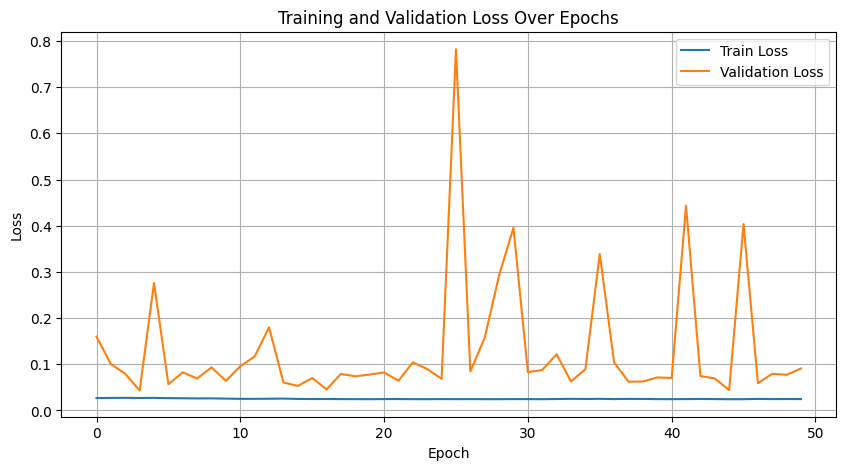

In [24]:
EPOCHS = 50
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model_path = "soc_dnn_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

### Testing

In [25]:
model_path = "soc_dnn_model.pth"

def load_model(model_path, input_size):
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_model(model_path, len(FEATURE_COLS))

In [26]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

In [27]:
# Calculate metrics MAE, MSE, STD
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)
stddev = np.std(test_labels_np - test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test StdDev: {stddev:.6f}")

Test MSE: 0.037208
Test MAE: 0.161848
Test StdDev: 0.175049


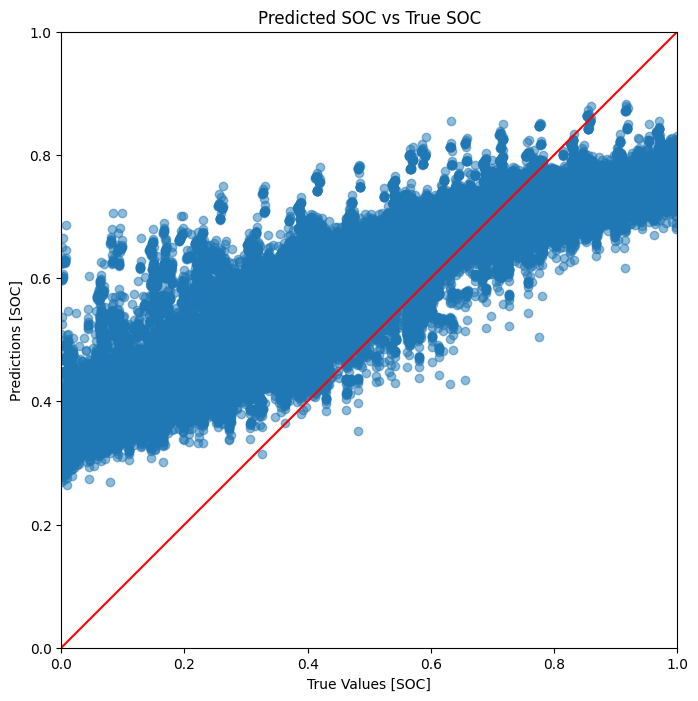

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

### Qualitative Comparison

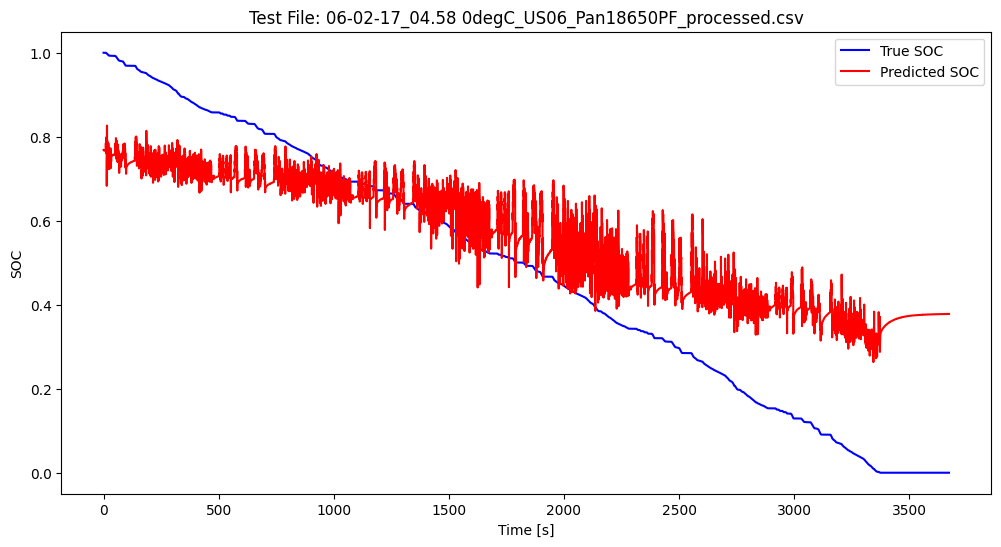

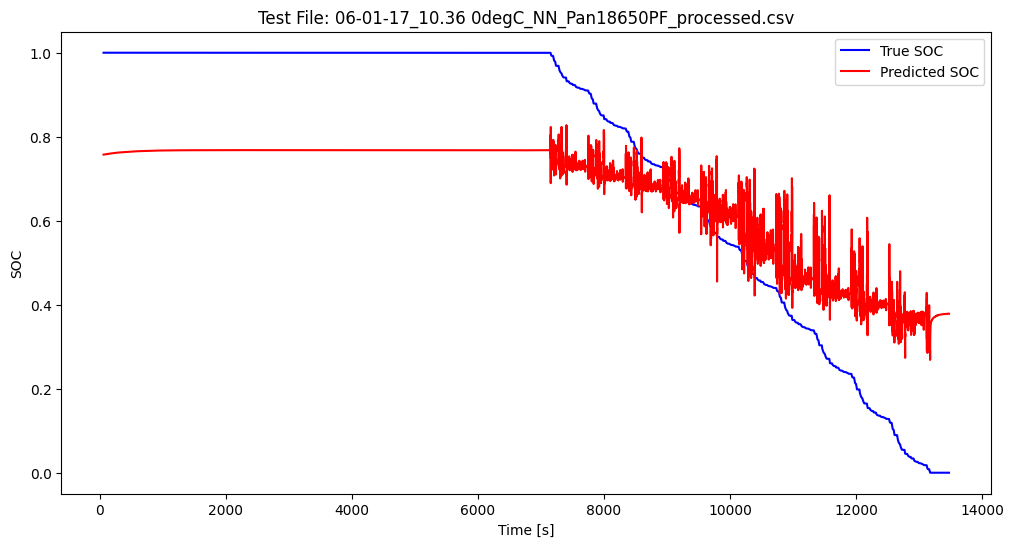

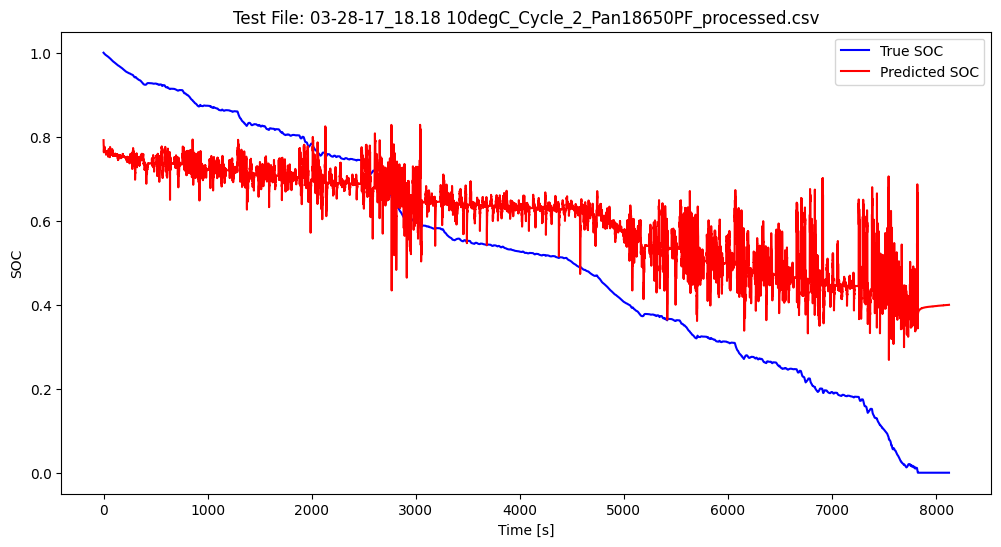

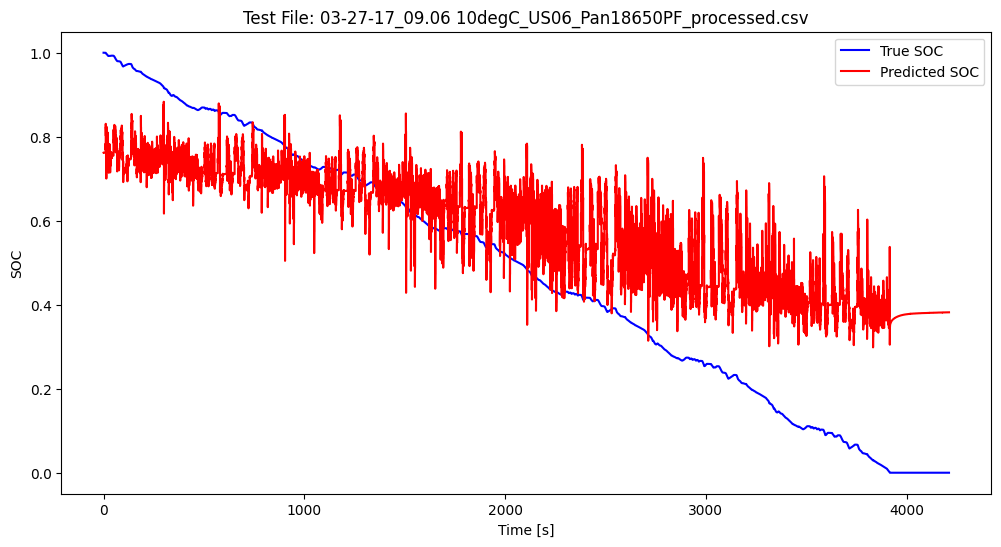

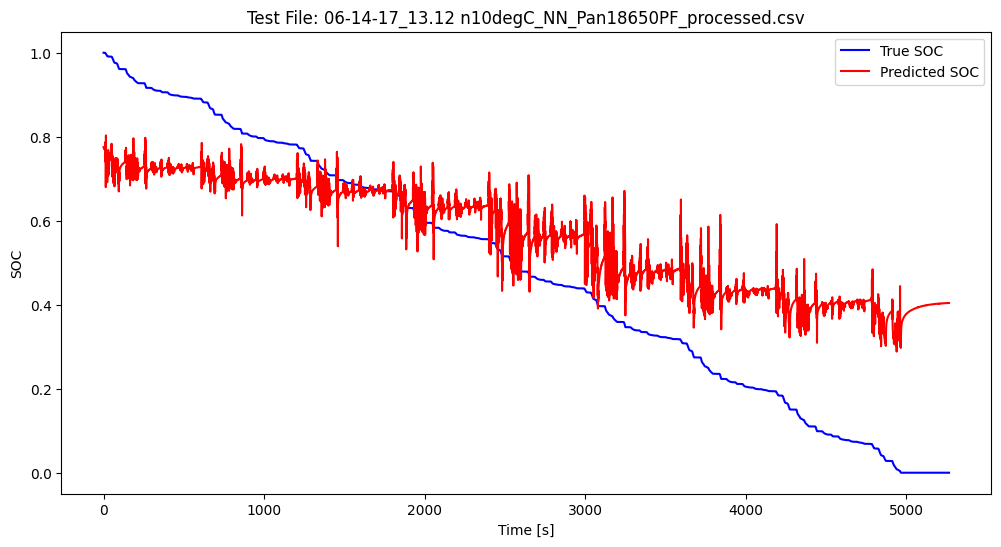

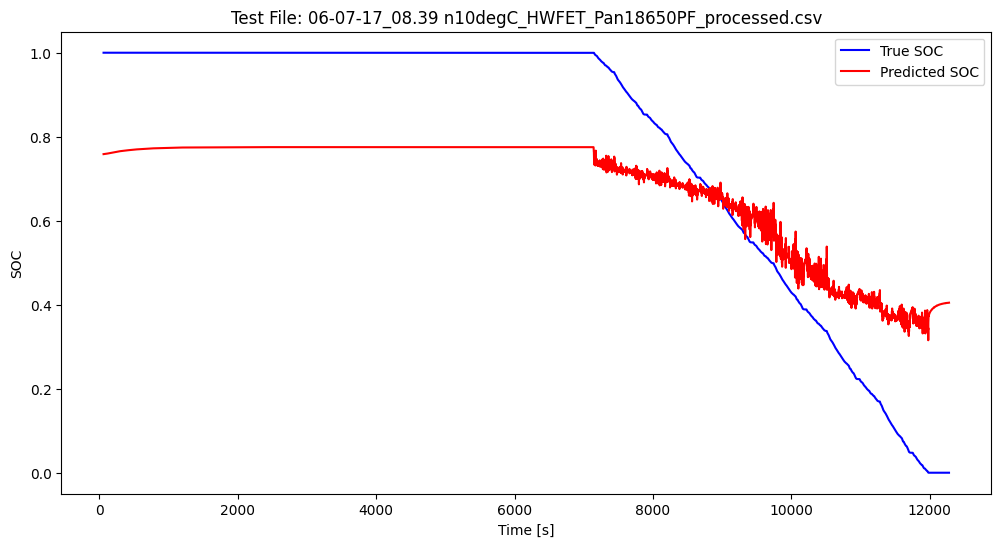

In [29]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)